# Real World Smartphones SVR

## Libraries

In [25]:
import pandas as pd
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt

## Preprocessing

### The dataset

In [26]:
data = pd.read_csv("../CSVs Cleaned/Cleaned smartphones.csv")
print(data.head())
y = data['price']

  brand_name       price  avg_rating  5G_or_not processor_brand  num_cores  \
0      apple  472.314400         7.3          0          bionic        6.0   
1      apple  569.201889         7.5          0          bionic        6.0   
2      apple  629.756570         7.4          1          bionic        6.0   
3      apple  678.200315         7.5          1          bionic        6.0   
4      apple  823.531549         7.6          1          bionic        6.0   

   processor_speed  battery_capacity  fast_charging_available  ram_capacity  \
0             2.65       3110.000000                        0             4   
1             2.65       3110.000000                        0             4   
2             3.10       4817.748194                        0             4   
3             3.10       4817.748194                        0             4   
4             3.10       4817.748194                        0             4   

   internal_memory  screen_size  refresh_rate  num_rear_

Using TargetEncoder to encode categorical features

In [27]:
encoder = TargetEncoder(target_type="continuous")
data['brand_name_encoded'] = encoder.fit_transform(data[['brand_name']], y)
data['processor_brand_encoded'] = encoder.fit_transform(data[['processor_brand']], y)
data['os_encoded'] = encoder.fit_transform(data[['os']], y)

del data['brand_name']
del data['processor_brand']
del data['os']

print(data.head())

        price  avg_rating  5G_or_not  num_cores  processor_speed  \
0  472.314400         7.3          0        6.0             2.65   
1  569.201889         7.5          0        6.0             2.65   
2  629.756570         7.4          1        6.0             3.10   
3  678.200315         7.5          1        6.0             3.10   
4  823.531549         7.6          1        6.0             3.10   

   battery_capacity  fast_charging_available  ram_capacity  internal_memory  \
0       3110.000000                        0             4               64   
1       3110.000000                        0             4              128   
2       4817.748194                        0             4               64   
3       4817.748194                        0             4              128   
4       4817.748194                        0             4              256   

   screen_size  refresh_rate  num_rear_cameras  primary_camera_rear  \
0          6.1            60                 

Drop samples with empty columns and separate features from target feature, price. Then select the top 10 features based on their mutual information (nat) score.

In [28]:
data = data.dropna()

y = data['price']
X = data.drop('price', axis=1)


mutual_info = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': mutual_info,
}).sort_values(by='Score', ascending=False)

# Display the feature importance scores
print(feature_scores)

select = SelectKBest(mutual_info_regression, k=10).fit(X, y)
X = select.transform(X)
print(f"\nSelected Features: {select.get_feature_names_out()}")

                      Feature     Score
0                  avg_rating  0.794565
3             processor_speed  0.606339
6                ram_capacity  0.536127
7             internal_memory  0.464183
12       primary_camera_front  0.424688
17    processor_brand_encoded  0.363200
11        primary_camera_rear  0.358227
15           resolution_width  0.351182
14          resolution_height  0.348211
13  extended_memory_available  0.280130
1                   5G_or_not  0.279476
8                 screen_size  0.279119
9                refresh_rate  0.256392
4            battery_capacity  0.249410
16         brand_name_encoded  0.200997
10           num_rear_cameras  0.167882
5     fast_charging_available  0.152398
2                   num_cores  0.099214
18                 os_encoded  0.044366

Selected Features: ['avg_rating' '5G_or_not' 'processor_speed' 'ram_capacity'
 'internal_memory' 'primary_camera_rear' 'primary_camera_front'
 'resolution_height' 'resolution_width' 'processor_brand_

## Training and testing

Scaling features

In [29]:
sc_X = StandardScaler()
sc_y = StandardScaler()
scaled_X = sc_X.fit_transform(X)
scaled_y = sc_y.fit_transform(y.to_numpy().reshape(-1, 1))

Split the dataset into test data and training data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=0.2)

Fit the training data to the model, and test by performing predictions on the test data

In [31]:
regressor = SVR()
regressor.fit(X_train, y_train)

pred = regressor.predict(X_test)
pred = pd.DataFrame(pred)

# Revert scaled values to price information
predicted_price = sc_y.inverse_transform(pred)
real_price = sc_y.inverse_transform(y_test)

c:\Users\andre\Documents\GitHub\Mobile-Phone-Price-Prediction\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Summarize performance

Train coeff of determination: 0.8336550088942248
Test coeff of determination: 0.8401897163741299
MAE: $43.53587698653243
MAPE: 0.18927027912461433


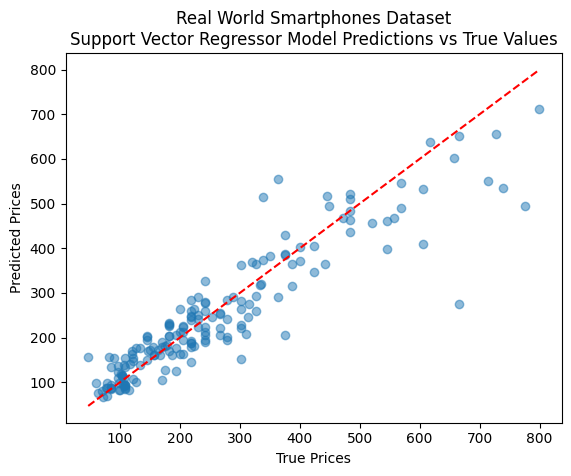

In [32]:
print(f"Train coeff of determination: {regressor.score(X_train, y_train)}")
print(f"Test coeff of determination: {regressor.score(X_test, y_test)}")
print(f"MAE: ${mean_absolute_error(real_price, predicted_price)}")
print(f"MAPE: {mean_absolute_percentage_error(real_price, predicted_price)}")

graph_points = len(y_test)
plt.scatter(real_price, predicted_price, alpha=0.5)
plt.plot([min(real_price), max(real_price)], [min(real_price), max(real_price)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Real World Smartphones Dataset\nSupport Vector Regressor Model Predictions vs True Values")
plt.show()